<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Marianna Abbattista](https://github.com/Mariabba), [Eleonora Cocciu](https://github.com/eleonoracocciu) and [Dafina Leva](https://github.com/dafina-95)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [4]:
%matplotlib inline

# general libraries
import sys
import math
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [5]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"
impunted_TR_file = data_directory + "Impunted_Train_HR_Employee_Attrition.csv"
clean_TR_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
clean_norm_TR_file = data_directory + "Cleaned_Normalized_Train_HR_Employee_Attrition.csv"
num_norm_TR_file = data_directory + "Numerical_Normalized_Train_HR_Employee_Attrition.csv"
cat_norm_TR_file = data_directory + "Categorical_Normalized_Train_HR_Employee_Attrition.csv"
num_TR_file = data_directory + "Numerical_Train_HR_Employee_Attrition.csv"
cat_TR_file = data_directory + "Categorical_Train_HR_Employee_Attrition.csv"

In [6]:
df_num = pd.read_csv(num_norm_TR_file) 
df_impunted = pd.read_csv(impunted_TR_file)

In [7]:
df_num.head()

Age  DistanceFromHome  MonthlyIncome  PercentSalaryHike  \
0  0.809524          0.285714       0.286171           0.428571   
1  0.428571          0.000000       0.147183           0.214286   
2  0.166667          0.535714       0.144644           1.000000   
3  0.357143          0.142857       0.068878           0.214286   
4  0.309524          0.285714       0.204325           0.071429   

   StockOptionLevel  TrainingTimesLastYear  YearsAtCompany  \
0          0.000000               0.333333            0.40   
1          0.333333               0.500000            0.05   
2          0.333333               0.666667            0.05   
3          0.000000               0.166667            0.15   
4          0.000000               0.333333            0.50   

   YearsInCurrentRole  MonthlyHours  Attrition  OverTime  OverallSatisfaction  \
0              0.4375      0.231122        0.0       0.0             0.333333   
1              0.5000      0.233476        0.0       1.0             0.333333   
2              0.3125      0.747017        0.0       1.0             0.666667   
3              0.4375      0.435214        0.0       0.0             0.333333   
4              0.1250      0.142192        0.0       0.0             0.666667   

   JobLevel  NumCompaniesWorked  Education  
0      0.50            1.000000       0.75  
1      1.00            0.111111       0.00  
2      0.25            0.111111       0.50  
3      0.00            0.222222       0.75  
4      0.00            0.111111       0.25

In [8]:
df_probe = df_num.copy()
del df_probe["Attrition"]
del df_probe["OverTime"]

<h2> Hierarchical clustering </h2>
Hierarchical approaches to clustering are useful when having an nested structure among the cluster is a necessity. The main drawbacks of such approaches are the time and space performances and, for this reasons, they're usually combined with other clustering analysis like k-means.

The hierarchy of clusters can be visualized with a dendogram: a tree structure where the horizontal lines represent the merging of two nodes, or clusters, and the vertical line provides information regarding the distance (or similarity) between said elements. By the end of the agglomerative bottom-up process, the dendrogram ends up displaying the whole merging process leading to a single universal cluster. Every number of clusters can be obtained by cutting the tree at the right level / height.


The first step is to compute the matrix accounting the distances among each of the point in our dataframe. Said computing can be performed by the <b>scipy.spatial.distance</b> function <b>pdist</b> or by specifying a particulare metric as a parameter of the <b>AgglomerativeClustering</b> class of <b>sklearn.cluster</b>.

Both alternatives are able to compute distances with respect to several well-known metrics or even custom ones specifically defined by the user. For the sake of this analysis, and due to the rich presence of continuous numerical data, we are going to select the <b>Euclidean distance as our metrics of choice</b>.

The second step is usually to chose a linkage method, that is chosing how the computation of the aforementioned distance is going to be performed. Again, the list of methods for linkage contains several choices, mainly leading to:

- Max / Complete-Linkage
- Min / Single-linkage
- Average-linkage
- Ward-linkage

We are going to analize and discuss the application of these main methods.

Optimal value of k in hierarchical clustering

Hiearchical approaches don't usually provide, at least explicity, an ideal number of clusters. 
The <b>best "cut" for the dendrogram is placed at a height where the line can traverse the maximum distance without intersecting an horizontal line</b> representing a merging point. Said method, however, is not perfect and the selection of an optimal k is often influenced by the characteristics of the dataset or the application of the clustering itself. Also, the <b>dendrogram function from scipy</b>, thanks to the <u>color_threshold</u> parameter, is able to highlight with different colors the links connecting nodes particularly close to each other, hence providing a powerful insight regarding the main clusters whitin the dataset.

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage, centroid, fcluster, cut_tree
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [10]:
def draw_silhouette(k, silhouette, method):
    # Create two subplots and unpack the output array immediately
    f, axs = plt.subplots(figsize=(5, 5))
    
    axs.plot(k, silhouette)
    plt.xlabel('K')
    plt.ylabel('SIL')
    plt.title('Silhouette Score for ' + str(method) + "-linkage")
    plt.show()

In [11]:
def interpret_dendogram(method):
    k = list(range(2, 13))
    silhouette = []
    for i in k:
        complete = AgglomerativeClustering(n_clusters=i, linkage=method, affinity='euclidean', connectivity=None)
        complete.fit(df_probe)
        hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))

        print('Cluster numbers: ', i)
        print('Cluster', dict(zip(bins, hist)))
        print('Silhouette Score', silhouette_score(df_probe, complete.labels_))
        silhouette.append(silhouette_score(df_probe, complete.labels_))
        
    draw_silhouette(k, silhouette, method)

In [12]:
def plot_dendrogram(model, cut_distance, linkage_mode, **kwargs):
    """
        Function which creates the linkage matrix (proximity/similarity matrix),
        with which plots the cooresponding obtained dendrogram.
    """
    # children_ = children of each non-leaf node
    # N.B. A node i greater than or equal to n_samples is a non-leaf node 
    # and has children children_[i - n_samples], with n_samples = len(labels_)
    counts = np.zeros(model.children_.shape[0])  
    n_samples = len(model.labels_) # labels_ = cluster labels for each point
    
    # create the counts of samples under each node:
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    # add cut line according to silhouette score
    plt.axhline(y=cut_distance, c='k', linestyle="--", label="SIL cut")
    
    plt.title('Hierarchical Clustering by ' + str(linkage_mode))
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()

<h6>The Nearest Point Algorithm: single-linkage</h6>

For this algorithm, the proximity between two clusters is based on the proximity of the two closest points.
<b>It tends to perform similarly to DBSCAN</b>.

While most of the linkage methods tends to prefer clusters of globular shapers, the main advantage of this approach is being able to <b>recognize non-elliptical clusters</b>, too. On the other way, the single-linkage is notoriously <b>sensitive to noise and outliers</b> (we could expect unrelated clusters being clumped together by one of these noisy point).

In [13]:
# We want to compute the entire tree
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                               linkage='single').fit(df_probe)

Cluster numbers:  2
Cluster {0: 882, 1: 1}
Silhouette Score 0.20996634036322978
Cluster numbers:  3
Cluster {0: 881, 1: 1, 2: 1}
Silhouette Score 0.11827442823445423
Cluster numbers:  4
Cluster {0: 880, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.09245020379289519
Cluster numbers:  5
Cluster {0: 879, 1: 1, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.05405095951189765
Cluster numbers:  6
Cluster {0: 878, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.029771794258450626
Cluster numbers:  7
Cluster {0: 877, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
Silhouette Score 0.025093572503007613
Cluster numbers:  8
Cluster {0: 876, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
Silhouette Score 0.020364565163733982
Cluster numbers:  9
Cluster {0: 875, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
Silhouette Score -0.00986524440890818
Cluster numbers:  10
Cluster {0: 874, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Silhouette Score -0.01839183248591356
Cluster numbers:  11
Cluster {0: 873, 1: 1, 2: 1, 3: 1, 4:

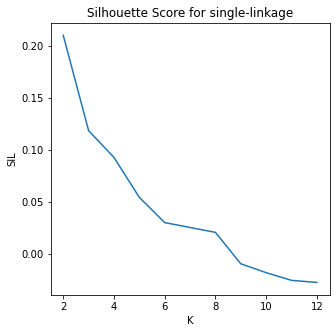

In [14]:
interpret_dendogram('single')

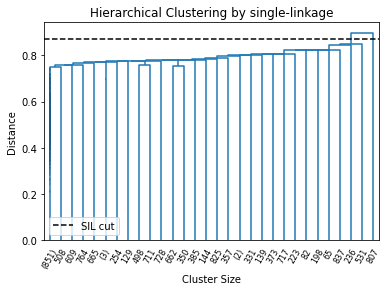

In [31]:
# We plot the dendrogram
cut_distance = 0.87
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='lastp', p=30, leaf_rotation=60, 
                leaf_font_size = 8, show_contracted=True)

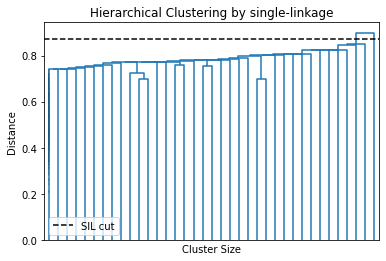

In [32]:
# We plot the dendrogram
cut_distance = 0.87
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='level', p=30, no_labels=True,
                leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

The single-linkage agglomerative clustering suggests the presence of 2 main cluster, being the result of the merging process of 2 main subclusters, one composed by 882 points and the second by a single point. As we can notice the first cluster is clumped together, probably due to the presence of noisy points that made its subcluster merge.

<h6> The Farthest Point Algorithm: complete-linkage </h6>
It is based on the complete (Max) linkage, measuring the proximity of two clusters by the distance of their fartherst points.

Being more <b>resistant to outliers and noise</b>, the complete-linkage should prove more reliable than the single one. However, one drowback is to <b>break the larger clusters into smaller globular ones</b>.

In [17]:
# We want to compute the entire tree
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                         linkage='complete').fit(df_probe)

Cluster numbers:  2
Cluster {0: 748, 1: 135}
Silhouette Score 0.11102623023338466
Cluster numbers:  3
Cluster {0: 135, 1: 677, 2: 71}
Silhouette Score 0.0812683943116742
Cluster numbers:  4
Cluster {0: 677, 1: 98, 2: 71, 3: 37}
Silhouette Score 0.07058731554237976
Cluster numbers:  5
Cluster {0: 555, 1: 98, 2: 71, 3: 37, 4: 122}
Silhouette Score 0.06617422523649884
Cluster numbers:  6
Cluster {0: 534, 1: 98, 2: 71, 3: 37, 4: 122, 5: 21}
Silhouette Score 0.05578042557137194
Cluster numbers:  7
Cluster {0: 98, 1: 122, 2: 71, 3: 37, 4: 156, 5: 21, 6: 378}
Silhouette Score 0.06537902729450913
Cluster numbers:  8
Cluster {0: 122, 1: 156, 2: 71, 3: 37, 4: 65, 5: 21, 6: 378, 7: 33}
Silhouette Score 0.06509836969535403
Cluster numbers:  9
Cluster {0: 156, 1: 33, 2: 71, 3: 37, 4: 65, 5: 21, 6: 378, 7: 33, 8: 89}
Silhouette Score 0.06299364704705533
Cluster numbers:  10
Cluster {0: 33, 1: 37, 2: 71, 3: 143, 4: 65, 5: 21, 6: 378, 7: 33, 8: 89, 9: 13}
Silhouette Score 0.06240325191034436
Cluster n

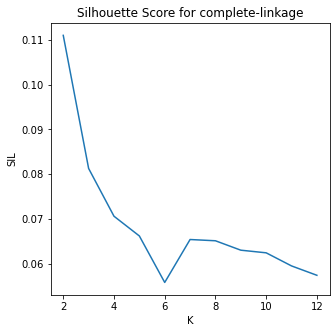

In [18]:
interpret_dendogram('complete')

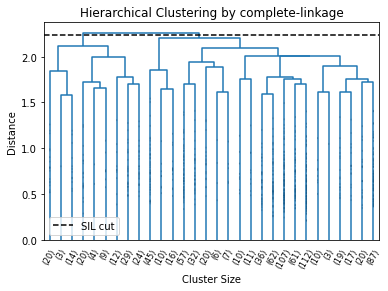

In [38]:
# We plot the dendrogram
cut_distance = 2.24
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='lastp', 
                                                    p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

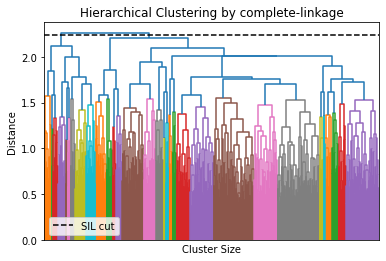

In [39]:
# We plot the dendrogram
cut_distance = 2.24
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='level', p=30, leaf_rotation=60, 
                no_labels=True, leaf_font_size = 8, show_contracted=True)

The comple-linkage agglomerative clustering suggests the presence of 2 main cluster, being the result of the merging process of 2 main subclusters, the first composed by 748 points, the second by 135 points. As we can notice from the dendogram, usually these main clusters are the result of fragmented subcluster merged together (the drawback of comple-linkage is to break big clusters into smaller ones).

<h6> The UPGMA Algorithm: average-linkage </h6>
It stands as a <b>trade-off between the complete and single linkages</b>. The proximity of two clusters is the average of the pairwise proximity between the points of the two clusters.
As the complete linkage, it is <b>less susceptible to noise and outliers</b>, but it also tends to </b>prefer globular clusters</b>.

In [21]:
# We want to compute the entire tree
model_average = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                        linkage='average').fit(df_probe)

Cluster numbers:  2
Cluster {0: 881, 1: 2}
Silhouette Score 0.22976896539418065
Cluster numbers:  3
Cluster {0: 861, 1: 2, 2: 20}
Silhouette Score 0.15587687556487587
Cluster numbers:  4
Cluster {0: 20, 1: 848, 2: 13, 3: 2}
Silhouette Score 0.12959062455376033
Cluster numbers:  5
Cluster {0: 13, 1: 848, 2: 3, 3: 2, 4: 17}
Silhouette Score 0.11076338746810525
Cluster numbers:  6
Cluster {0: 848, 1: 10, 2: 3, 3: 2, 4: 17, 5: 3}
Silhouette Score 0.08927668976211135
Cluster numbers:  7
Cluster {0: 845, 1: 10, 2: 3, 3: 2, 4: 17, 5: 3, 6: 3}
Silhouette Score 0.05721085798582834
Cluster numbers:  8
Cluster {0: 10, 1: 839, 2: 3, 3: 6, 4: 17, 5: 3, 6: 3, 7: 2}
Silhouette Score 0.028313161278657805
Cluster numbers:  9
Cluster {0: 839, 1: 17, 2: 3, 3: 6, 4: 8, 5: 3, 6: 3, 7: 2, 8: 2}
Silhouette Score 0.020839825224423285
Cluster numbers:  10
Cluster {0: 74, 1: 765, 2: 3, 3: 6, 4: 17, 5: 3, 6: 3, 7: 2, 8: 2, 9: 8}
Silhouette Score 0.02676690103845439
Cluster numbers:  11
Cluster {0: 765, 1: 17, 2:

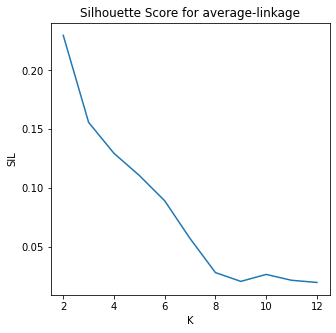

In [22]:
interpret_dendogram('average')

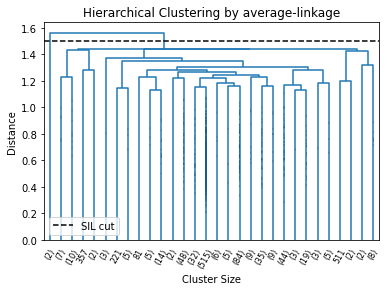

In [40]:
cut_distance = 1.50
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='lastp',
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

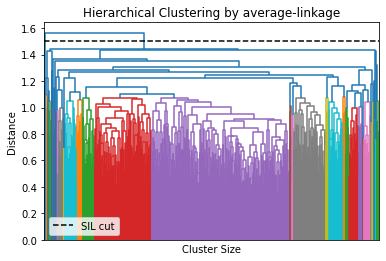

In [41]:
cut_distance = 1.50
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

The average-linkage agglomerative clustering suggests the presence of 2 main cluster, being the result of the merging process of 2 main subclusters, one composed by 2 points and the second by 881 points.
Since it is a trade-off between the complete and single linkages, we can again see how it is susceptile to noise, noticing, however, that the subclusters are less clumped together. 

<h6> The Incremental Algorithm: ward-linkage </h6>
It stands as the hierarchical <b>analogue of K-means</b> and, like the former, it is a <b>centroid based approach</b> with a particular interest in the minimization of the SSE values associated with each cluster.

In [25]:
# We want to compute the entire tree
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='ward').fit(df_probe)

Cluster numbers:  2
Cluster {0: 644, 1: 239}
Silhouette Score 0.08962544468941869
Cluster numbers:  3
Cluster {0: 239, 1: 513, 2: 131}
Silhouette Score 0.06241604343814029
Cluster numbers:  4
Cluster {0: 513, 1: 108, 2: 131, 3: 131}
Silhouette Score 0.06704861533869504
Cluster numbers:  5
Cluster {0: 459, 1: 108, 2: 131, 3: 131, 4: 54}
Silhouette Score 0.07426434047308857
Cluster numbers:  6
Cluster {0: 244, 1: 108, 2: 215, 3: 131, 4: 54, 5: 131}
Silhouette Score 0.05942001268924123
Cluster numbers:  7
Cluster {0: 215, 1: 108, 2: 118, 3: 131, 4: 54, 5: 131, 6: 126}
Silhouette Score 0.05320767034264926
Cluster numbers:  8
Cluster {0: 108, 1: 87, 2: 118, 3: 131, 4: 54, 5: 131, 6: 126, 7: 128}
Silhouette Score 0.041951324806148584
Cluster numbers:  9
Cluster {0: 87, 1: 131, 2: 118, 3: 70, 4: 54, 5: 131, 6: 126, 7: 128, 8: 38}
Silhouette Score 0.04266847726236017
Cluster numbers:  10
Cluster {0: 118, 1: 131, 2: 126, 3: 70, 4: 54, 5: 131, 6: 45, 7: 128, 8: 38, 9: 42}
Silhouette Score 0.0388

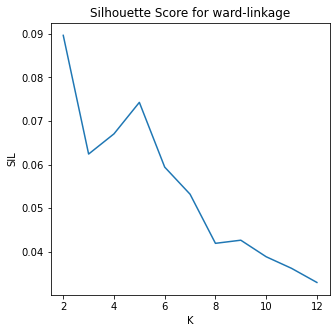

In [26]:
interpret_dendogram('ward')

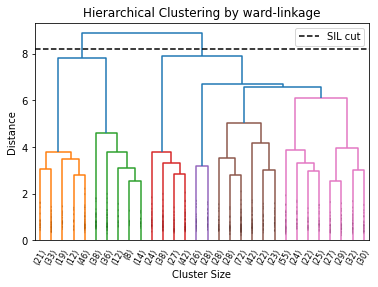

In [27]:
# We plot the dendrogram
cut_distance = 8.2
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='lastp', 
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

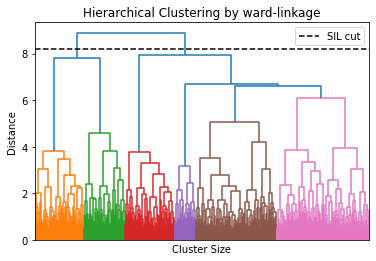

In [28]:
# We plot the dendrogram
cut_distance = 8.2
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

Since this linkage metric used to merged similar cluster best resembles the K-Means, we expected a correspondence with the best k previously evaluate with the Elbow Method. Here, however, the dendrogram seems to suggest the presence of 2 main clusters, a larger one (644 points) and three smaller ones (239 points). 

As we can clearly see the larger cluster is divided in two subcluster, which with K-Means weren't generalized, since the smaller candicate for the number of cluster k is set to ?. 

<h6> Best linkage function selection </h6>
In our opinion the best linkage fucntion for our dataset is the <b>ward-linkage</b>. We will be less restrictive with the cut_off level in our analysis, using a k=4 and a k=6 from graphical inspection. These choises are a validatation and a conforn with K-Means values, too.

<h2>k=4</h2>

In [42]:
k = 4
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_probe)
cluster_label = str(k) + "cluster_label"
df_num[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 
df_impunted[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 

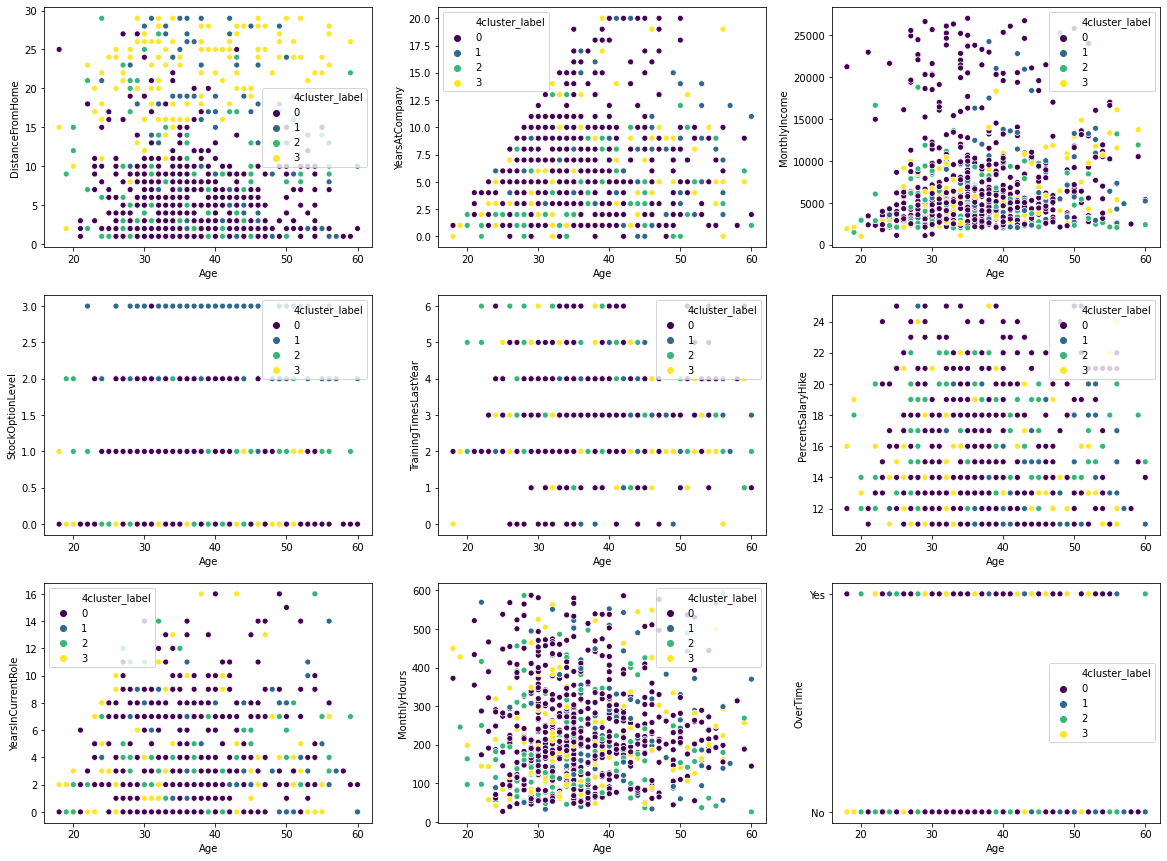

In [43]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['DistanceFromHome'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsAtCompany'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyIncome'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['StockOptionLevel'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['TrainingTimesLastYear'], 
                                                                 hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['PercentSalaryHike'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsInCurrentRole'], 
                                                             hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyHours'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverTime'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

plt.show()

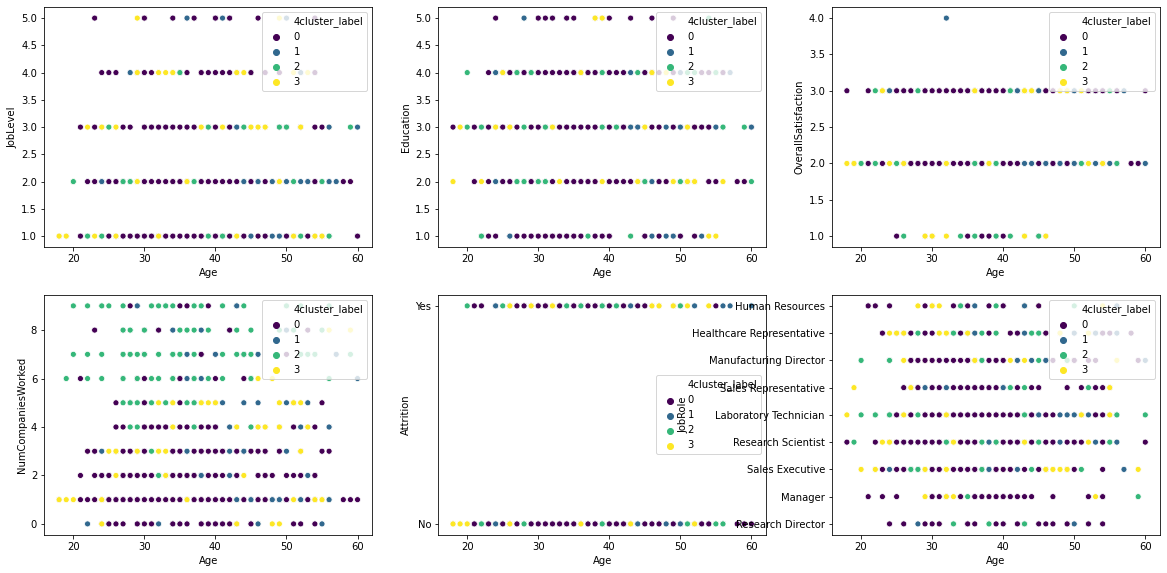

In [44]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobLevel'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Education'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverallSatisfaction'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['NumCompaniesWorked'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Attrition'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobRole'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

plt.show()

In [45]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def plot_3d_scatterplot(df, x, y, y2, secondplot_flag):
    # axes instance
    fig = plt.figure(figsize=(20, 10))
    fig_dims = (1, 2)

    # plot
    ax = plt.subplot2grid(fig_dims, (0, 0), projection='3d')
    sc = ax.scatter(df[x].astype(int), df[y].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel("Attrition")
    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
    
    if secondplot_flag:
        # plot
        ax = plt.subplot2grid(fig_dims, (0, 1), projection='3d')
        try:
            sc = ax.scatter(df[x].astype(int), df[y2].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
        except ValueError:
            sc = ax.scatter(df[x].astype(int), df_num[y2], df_num["Attrition"], c=df_num[cluster_label], marker='o')
        ax.set_xlabel(x)
        ax.set_ylabel(y2)
        ax.set_zlabel("Attrition")
        # legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
        
    
    plt.show()

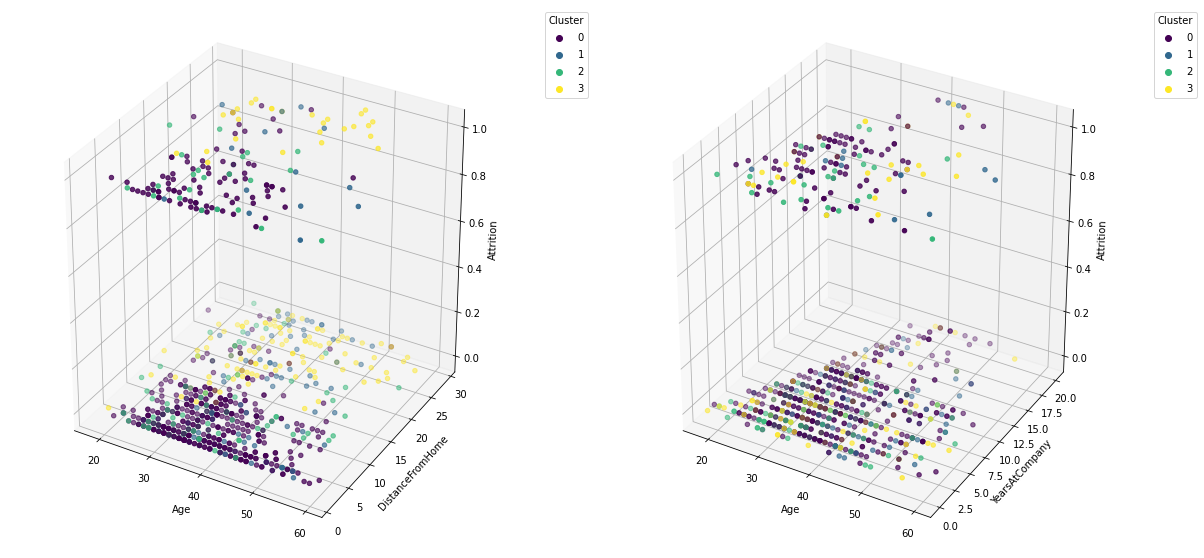

In [46]:
plot_3d_scatterplot(df_impunted, 'Age', 'DistanceFromHome', 'YearsAtCompany', True)

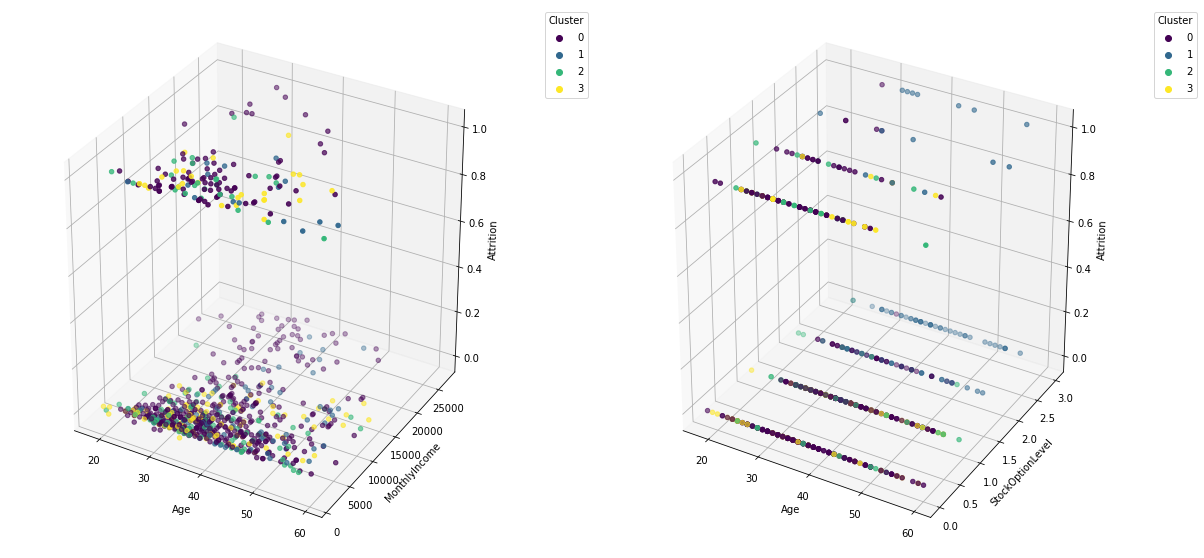

In [47]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyIncome', 'StockOptionLevel', True)

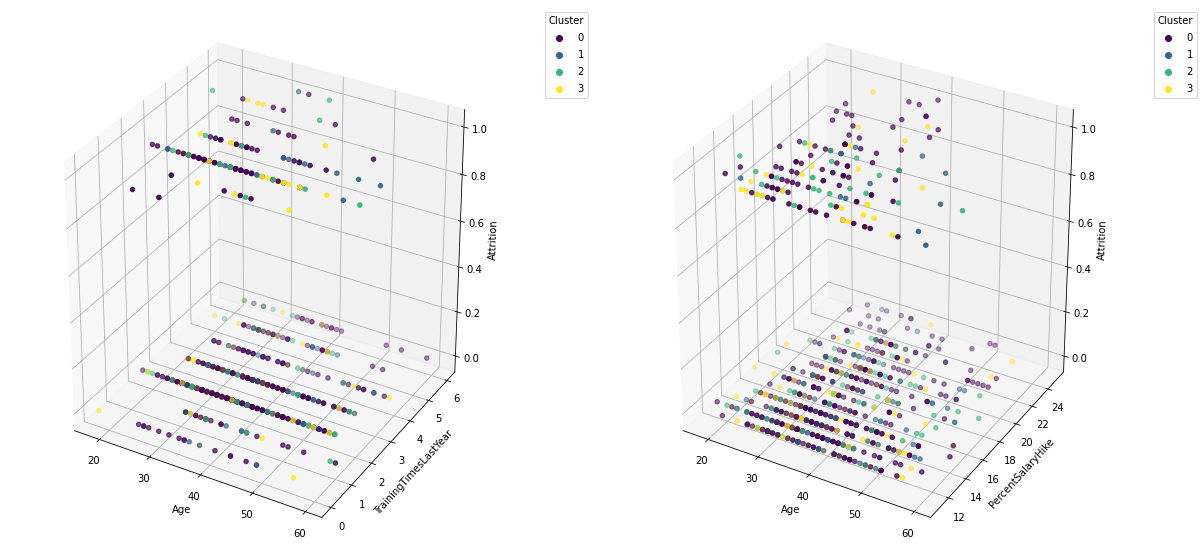

In [48]:
plot_3d_scatterplot(df_impunted, 'Age', 'TrainingTimesLastYear', 'PercentSalaryHike', True)

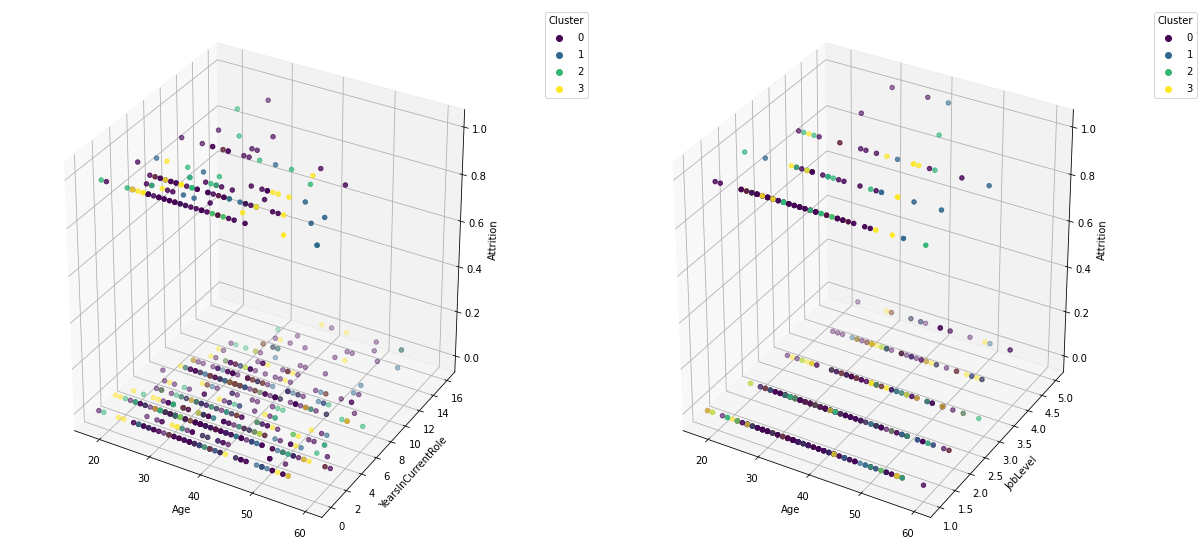

In [49]:
plot_3d_scatterplot(df_impunted, 'Age', 'YearsInCurrentRole', 'JobLevel', True)

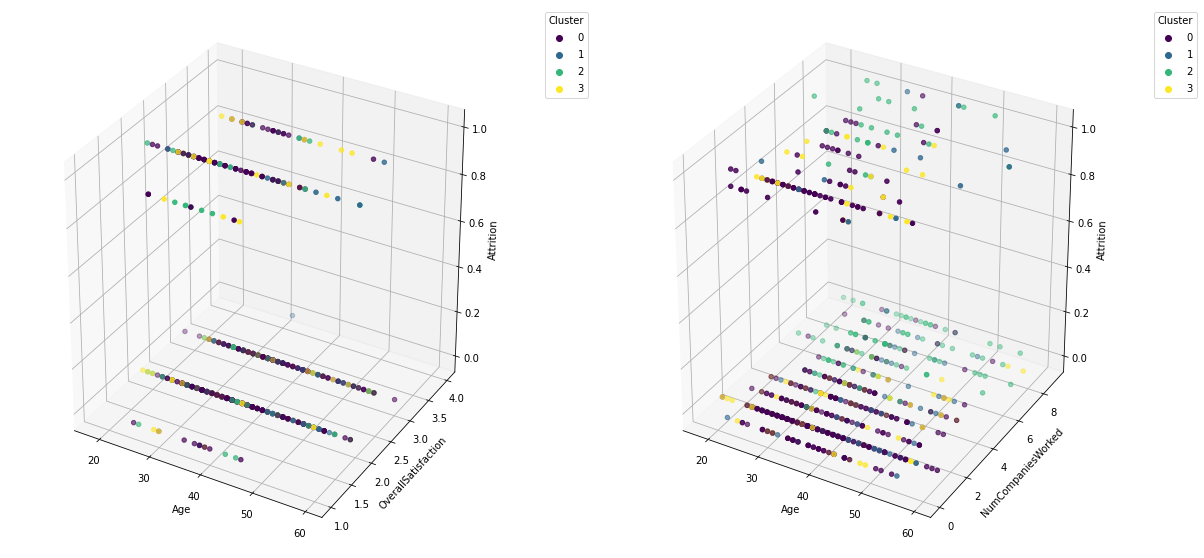

In [50]:
plot_3d_scatterplot(df_impunted, 'Age', 'OverallSatisfaction', 'NumCompaniesWorked', True)

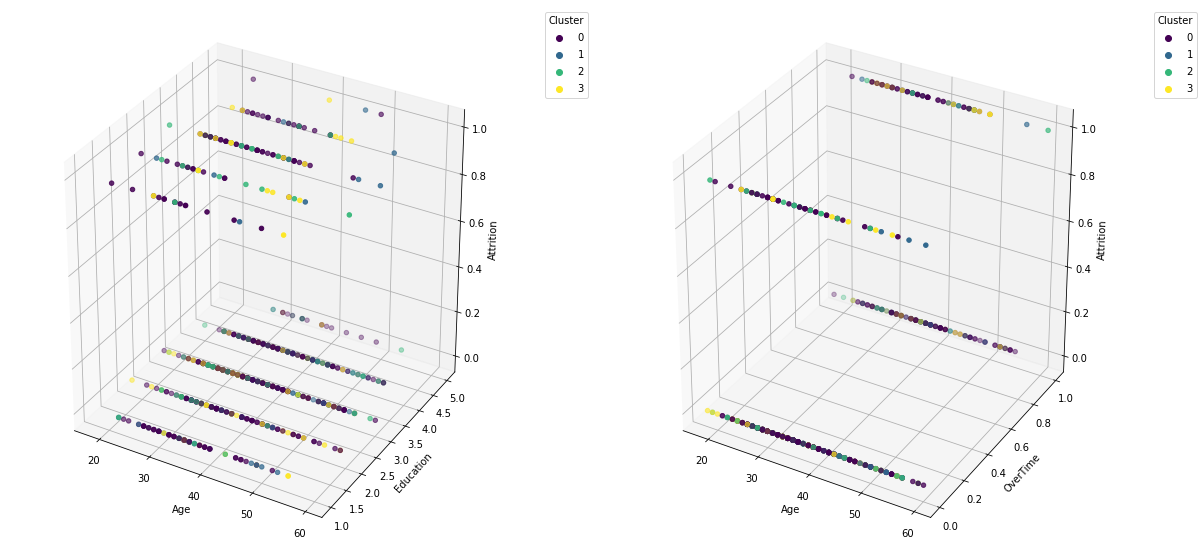

In [51]:
plot_3d_scatterplot(df_impunted, 'Age', 'Education', 'OverTime', True)

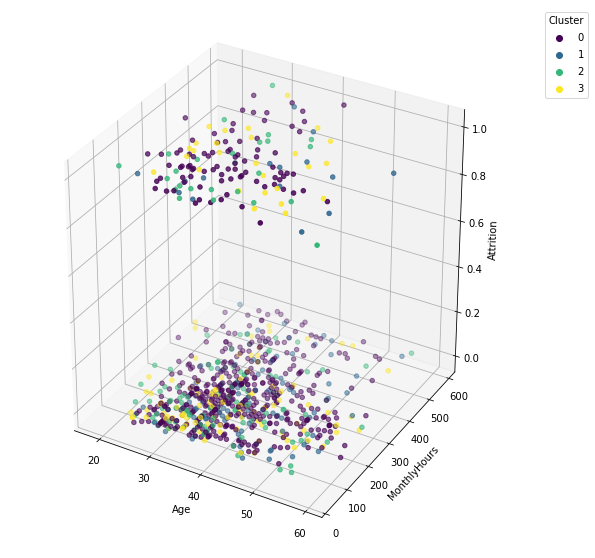

In [52]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyHours', "", False)

In [53]:
def draw_stacked_bar(column_name1, column_name2, df1, df2, annotate_flag, ax, xticks_rotation, loc, cmap, title):
    
    patch_handles = []
    frames = [df1[[column_name1]], df2[[column_name2]]]
    concat_df = pd.concat(frames, axis=1)  # merge Dataframes across columns
    
    # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(concat_df[column_name1], concat_df[column_name2]).dropna()
    if cmap != "":
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax, cmap=cmap))
    else:
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax))
    plt.xlabel(column_name1)
    plt.ylabel('count')
    plt.xticks(rotation=xticks_rotation)
    
    # get sub-DataFrame made out by column_name1 and column_name2 concatenation, without NaN values
    curr_df = concat_df[[column_name1, column_name2]].dropna()
    unique_values = sorted(curr_df[column_name1].unique())  # alphabetical order
    tmp_xticks_tot_elements = {}

    # search all of the bar segments and annotate
    for rec in ax.patches:
        height = rec.get_height()
        x = rec.get_x() + rec.get_width() / 2
        y = rec.get_y() + height / 2
        current_value = unique_values[int(x)]  # index with xticks unique column_name1's values
        tot_current_value = curr_df[curr_df[column_name1] == current_value][column_name1].shape[0] 
        percentage =  "{:.0f}%".format(height /tot_current_value*100)

        try:
            tmp_count = tmp_xticks_tot_elements[str(x)]
            tmp_count += height
            tmp_xticks_tot_elements[str(x)] = tmp_count
        except KeyError:
             tmp_xticks_tot_elements[str(x)] = height

        if annotate_flag:
            ax.text(x, y, percentage, ha='center', va='bottom')

    # put total number of elements on top of each bar
    for x, tot_x in tmp_xticks_tot_elements.items():
        ax.text(float(x), tot_x, str(int(tot_x)), ha='center', va='bottom')
        
    # adjust legend's position
    if loc != "":
        plt.legend(title=column_name2, loc=loc)
        
    plt.title(title)

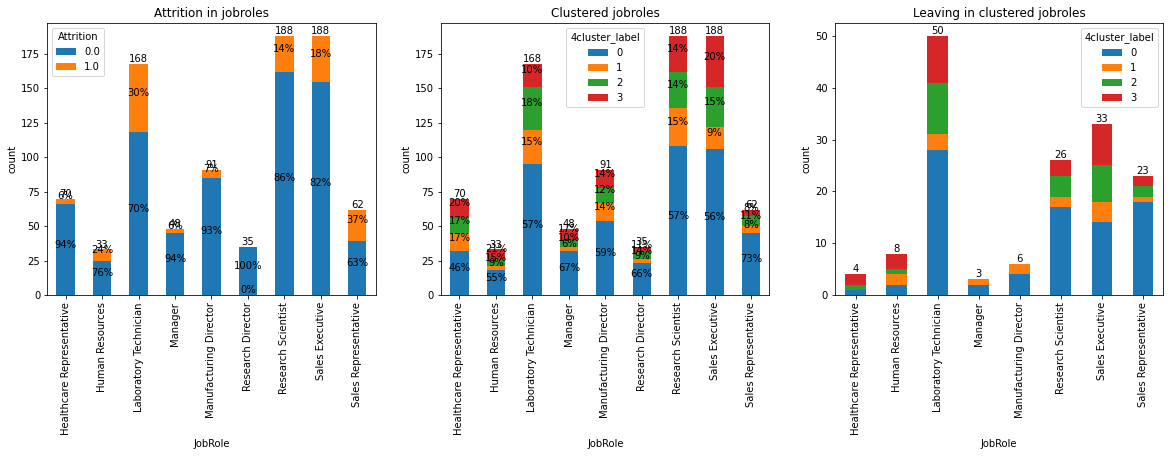

In [54]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "Attrition", df_impunted, df_num, True, ax, 90, "", "", "Attrition in jobroles")
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, cluster_label, df_impunted,  df_num, True, ax, 90, "", "", "Clustered jobroles")
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, cluster_label, df_impunted[df_impunted["Attrition"] == "Yes"], 
                 df_num[df_num["Attrition"] == 1], False, ax, 90, "", "", "Leaving in clustered jobroles")

<h2>k=6</h2>

In [90]:
k = 6
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_probe)
cluster_label = str(k) + "cluster_label"
df_num[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 
df_impunted[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 

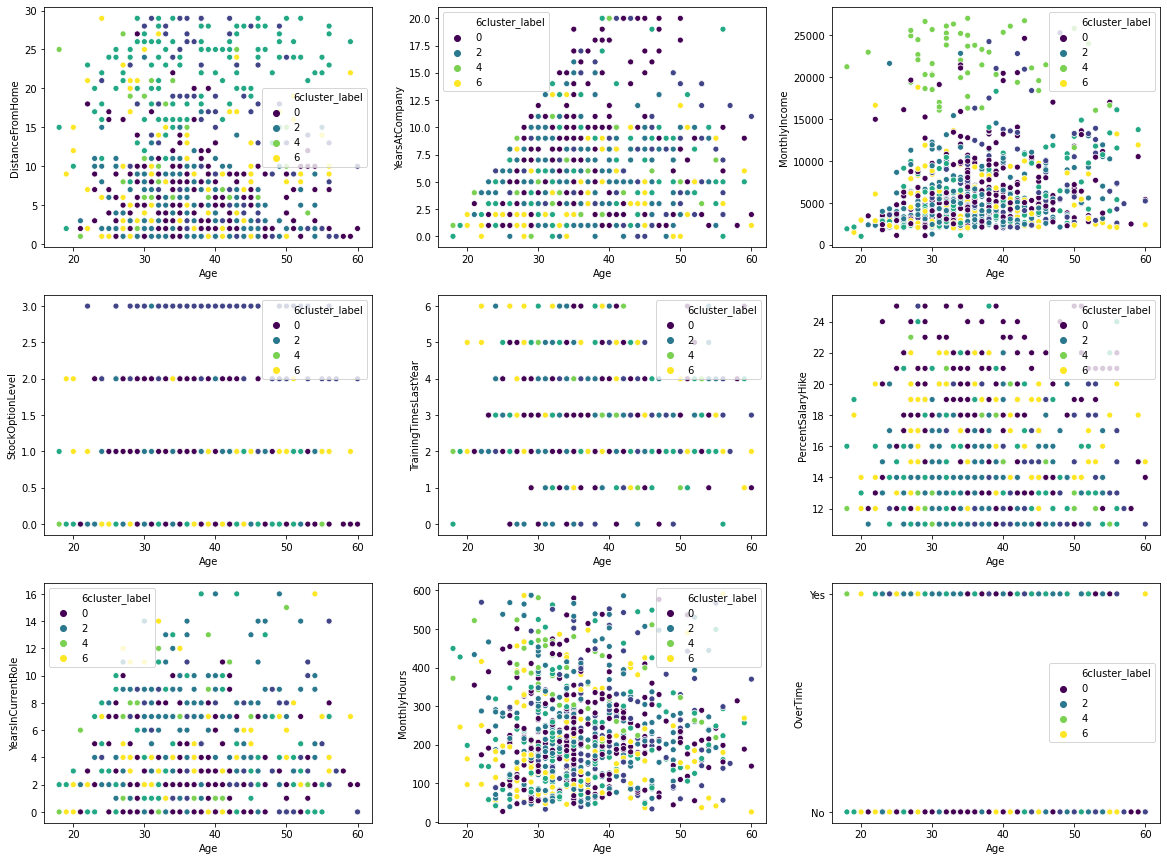

In [91]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['DistanceFromHome'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsAtCompany'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyIncome'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['StockOptionLevel'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['TrainingTimesLastYear'], 
                                                                 hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['PercentSalaryHike'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsInCurrentRole'], 
                                                             hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyHours'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverTime'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

plt.show()

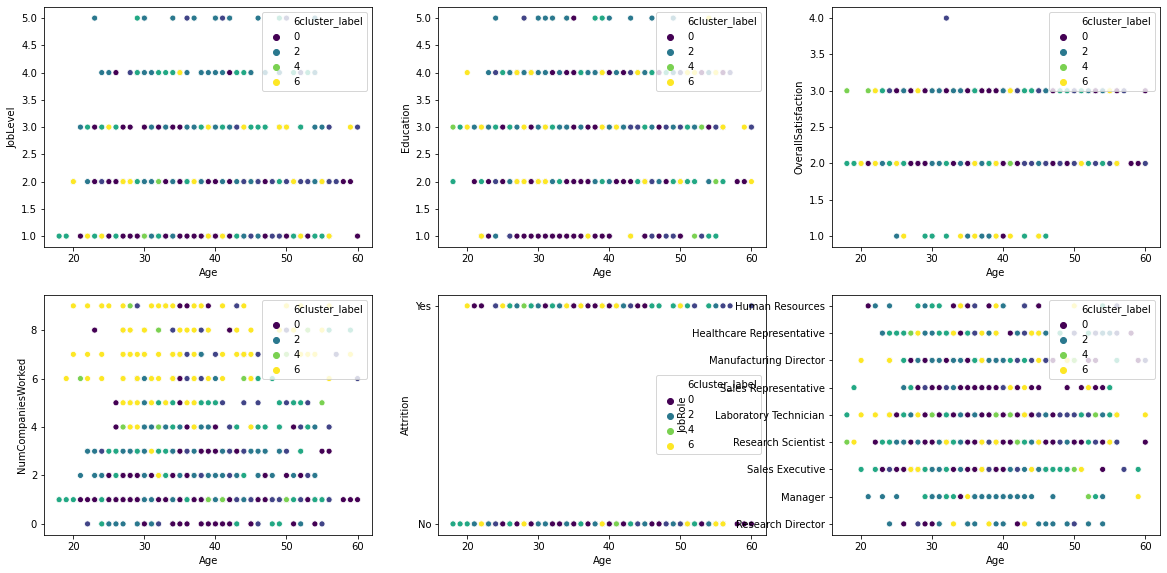

In [92]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobLevel'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Education'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverallSatisfaction'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['NumCompaniesWorked'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Attrition'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobRole'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

plt.show()

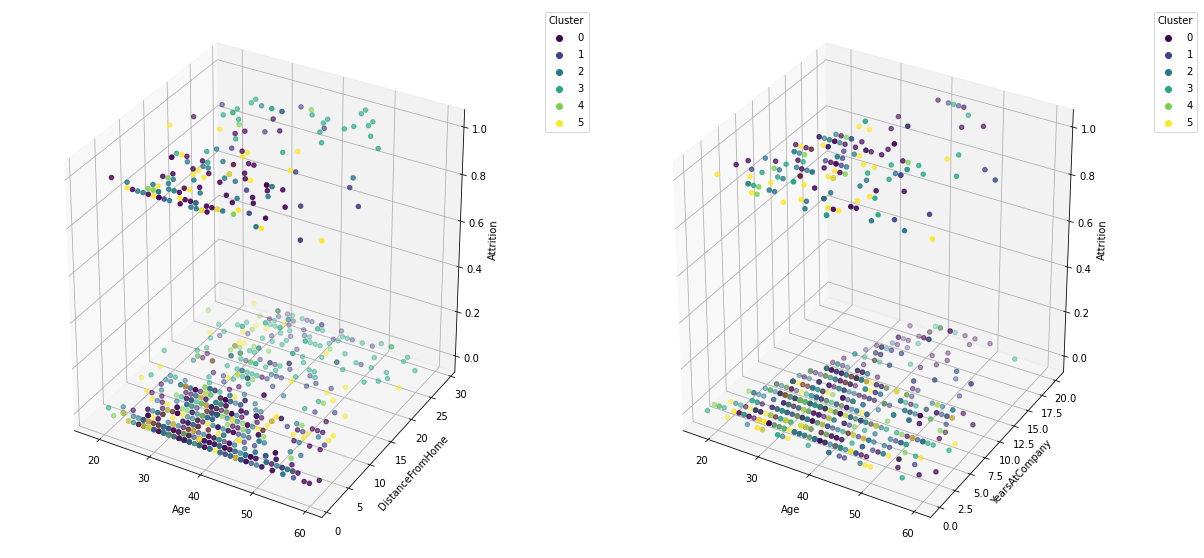

In [93]:
plot_3d_scatterplot(df_impunted, 'Age', 'DistanceFromHome', 'YearsAtCompany', True)

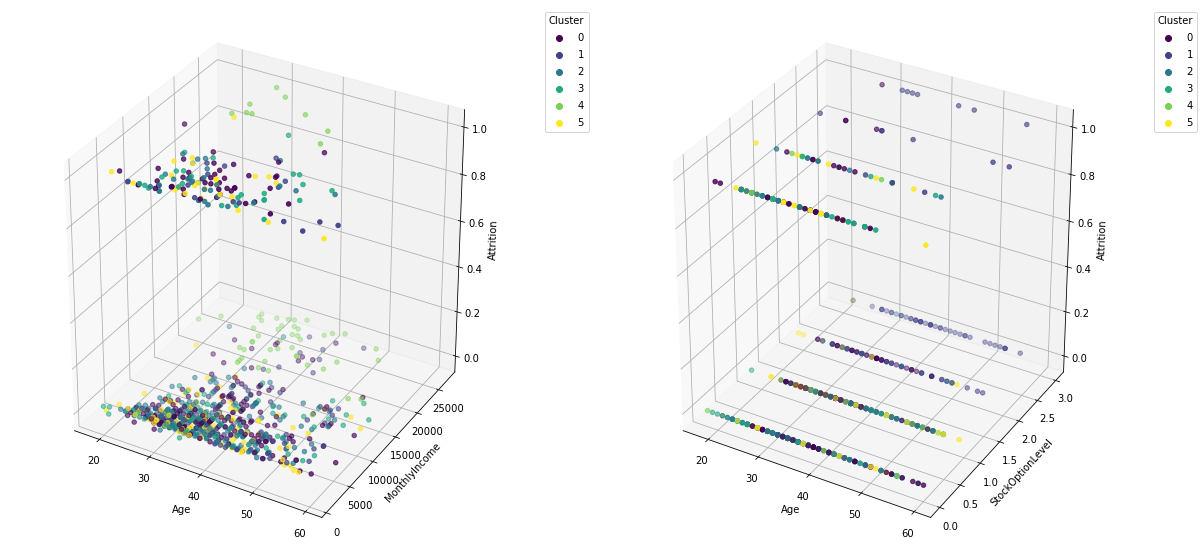

In [94]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyIncome', 'StockOptionLevel', True)

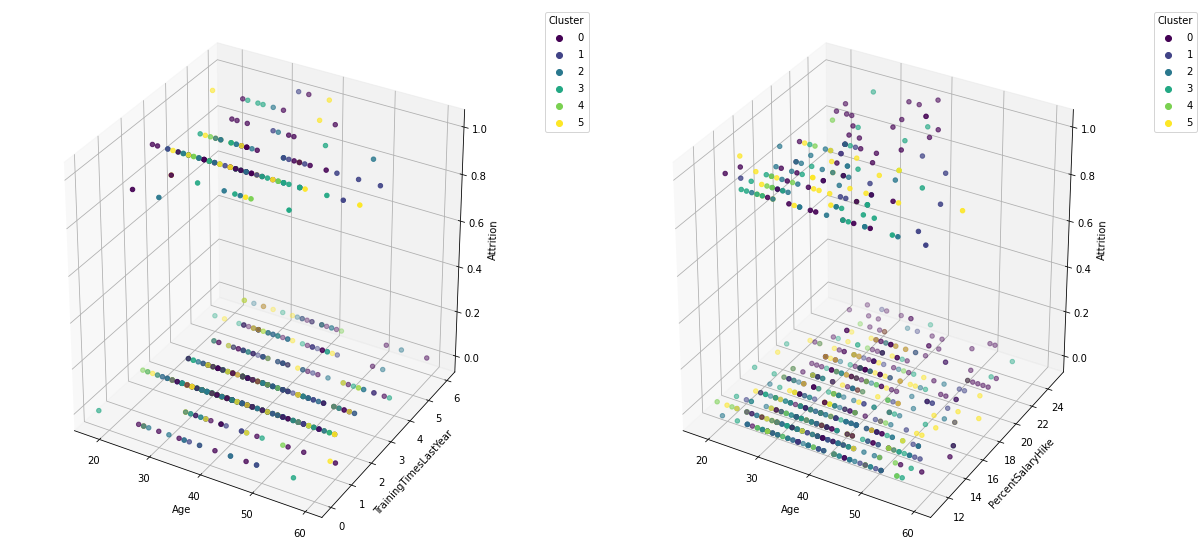

In [95]:
plot_3d_scatterplot(df_impunted, 'Age', 'TrainingTimesLastYear', 'PercentSalaryHike', True)

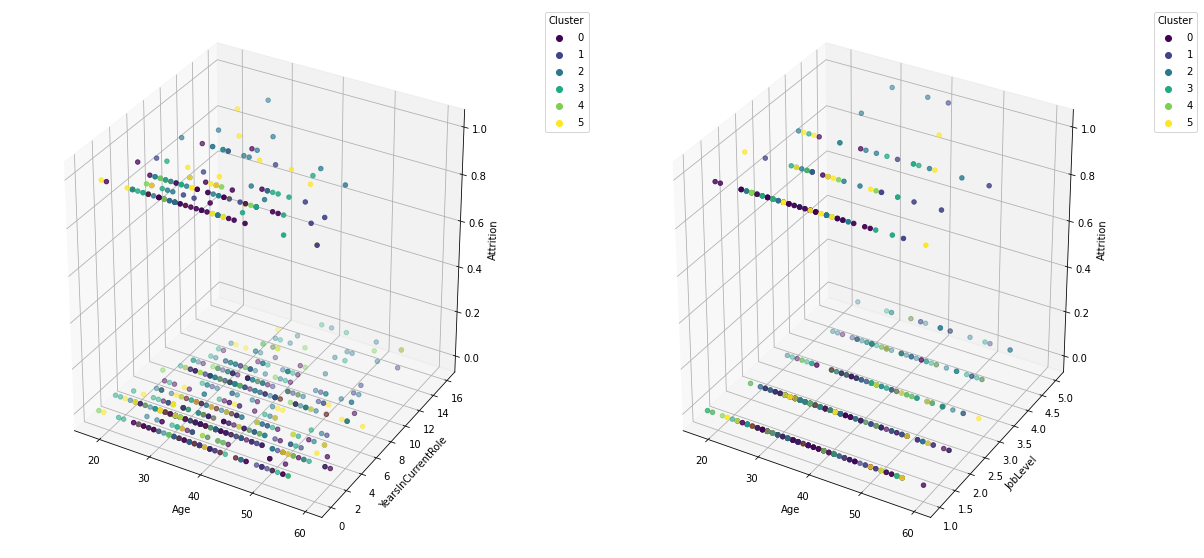

In [96]:
plot_3d_scatterplot(df_impunted, 'Age', 'YearsInCurrentRole', 'JobLevel', True)

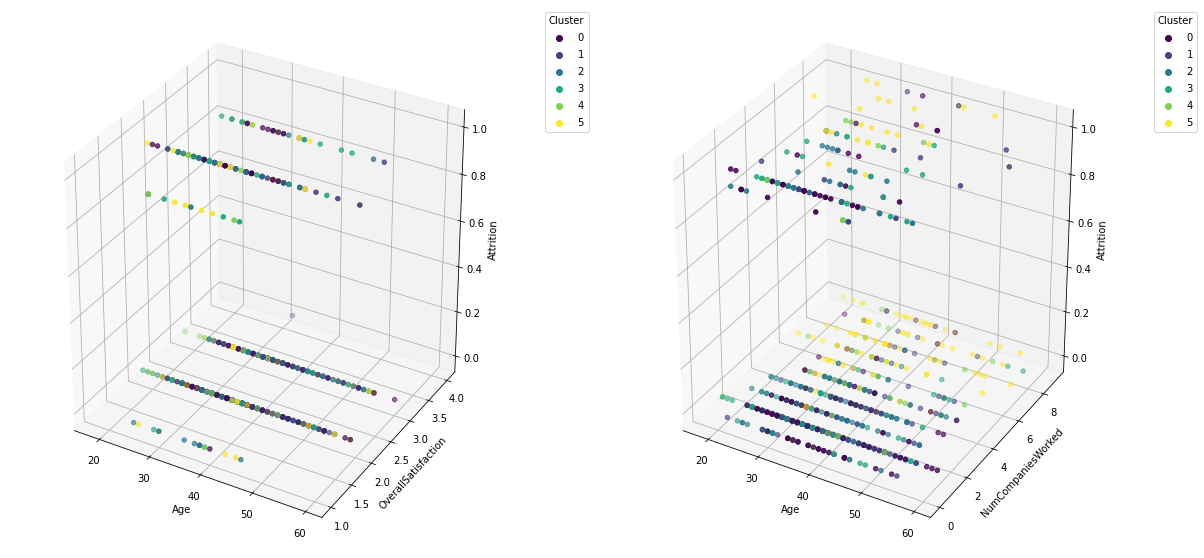

In [97]:
plot_3d_scatterplot(df_impunted, 'Age', 'OverallSatisfaction', 'NumCompaniesWorked', True)

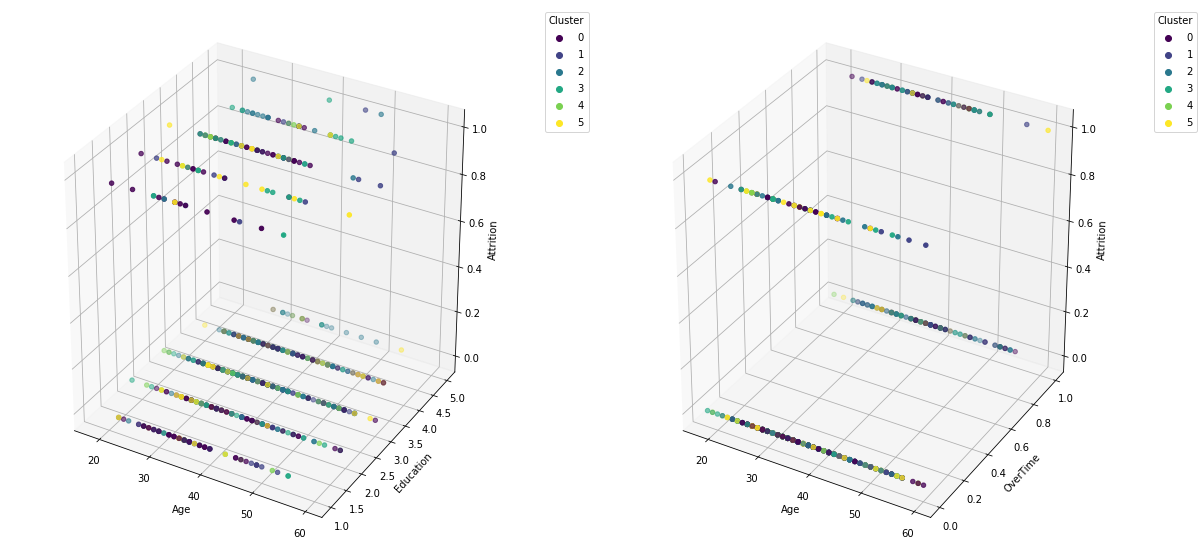

In [98]:
plot_3d_scatterplot(df_impunted, 'Age', 'Education', 'OverTime', True)

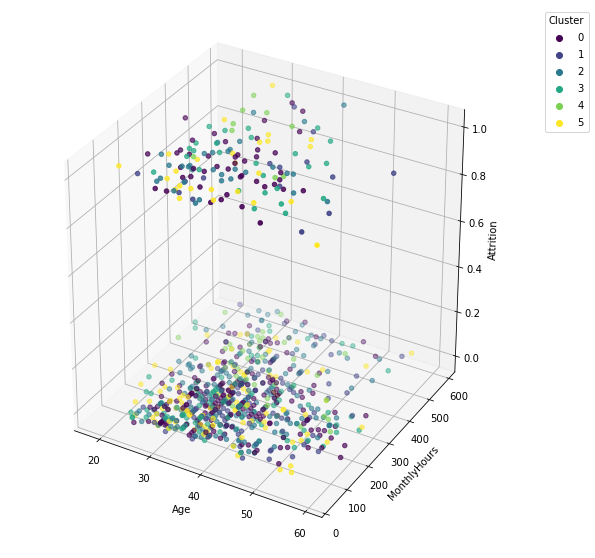

In [99]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyHours', "", False)

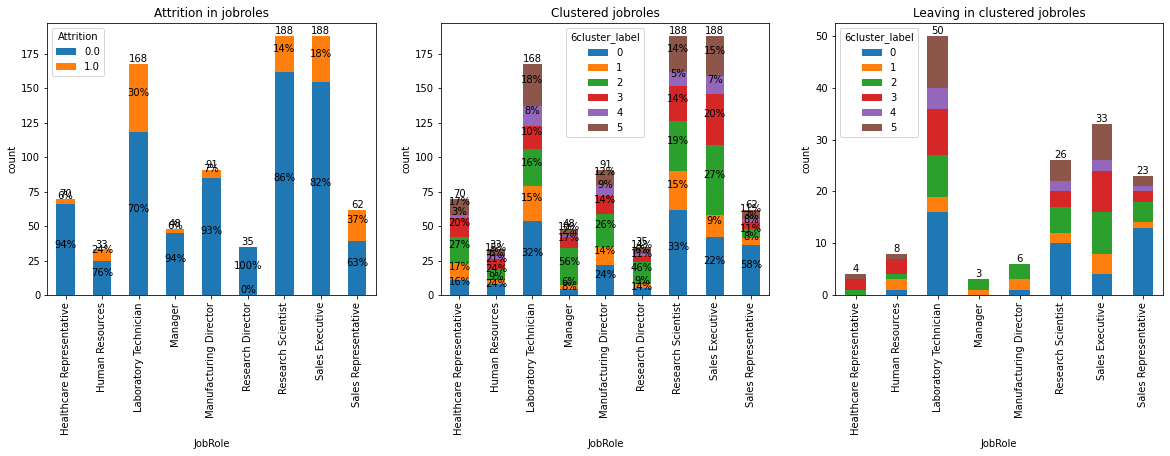

In [100]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "Attrition", df_impunted, df_num, True, ax, 90, "", "", "Attrition in jobroles")
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, cluster_label, df_impunted,  df_num, True, ax, 90, "", "", "Clustered jobroles")
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, cluster_label, df_impunted[df_impunted["Attrition"] == "Yes"], 
                 df_num[df_num["Attrition"] == 1], False, ax, 90, "", "", "Leaving in clustered jobroles")